In [2]:
#basic data tools
import pandas as pd
import numpy as np

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Ml models
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import silhouette_score

In [4]:
#loading CSV files
orders = pd.read_csv("orders.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")

In [5]:
#merge product information with aisle and department
products_full = (
    products
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

products_full.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [6]:
#merge prior order products with the full product table
order_details = order_products_prior.merge(products_full, on="product_id", how="left")
order_details.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [7]:
#merge with orders table to attach order level data
order_data = order_details.merge(orders, on="order_id", how="left")
order_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [8]:
#shape of the combined dataset
order_data.shape

(32434489, 15)

In [9]:
#look at the first few rows
order_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [10]:
#check missing values
order_data.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64

In [11]:
#check duplicates
order_data.duplicated().sum()

np.int64(0)

In [12]:
# CUSTOMER RFM FEATURES

# Frequency = how many orders per user
frequency = order_data.groupby("user_id")["order_number"].max().reset_index()
frequency.columns = ["user_id", "frequency"]

# Recency = days since prior order (take the last order's recency)
recency = order_data.groupby("user_id")["days_since_prior_order"].max().reset_index()
recency.columns = ["user_id", "recency"]

# Monetary = average basket size (items per order)
basket_sizes = order_data.groupby(["user_id", "order_id"]).size().reset_index(name="basket_size")
monetary = basket_sizes.groupby("user_id")["basket_size"].mean().reset_index()
monetary.columns = ["user_id", "monetary"]

# Combine RFM into one table
customer_rfm = frequency.merge(recency, on="user_id").merge(monetary, on="user_id")
customer_rfm.head()

,user_id,frequency,recency,monetary
0,1,10,30.0,5.900000
1,2,14,30.0,13.928571
2,3,12,21.0,7.333333
3,4,5,21.0,3.600000
4,5,4,19.0,9.250000


In [13]:
# Select RFM columns
rfm_values = customer_rfm[["recency", "frequency", "monetary"]]

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_values)

rfm_scaled[:5]

array([[ 0.55577461, -0.33566236, -0.69097766],
       [ 0.55577461, -0.0954904 ,  0.67825489],
       [-0.79668798, -0.21557638, -0.44652986],
       [-0.79668798, -0.63587732, -1.08323112],
       [-1.09723522, -0.69592031, -0.11965198]])

In [14]:
# Try KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
customer_rfm["cluster"] = kmeans.fit_predict(rfm_scaled)

customer_rfm.head()

,user_id,frequency,recency,monetary,cluster
0,1,10,30.0,5.900000,1
1,2,14,30.0,13.928571,0
2,3,12,21.0,7.333333,2
3,4,5,21.0,3.600000,1
4,5,4,19.0,9.250000,2


In [15]:
customer_rfm["cluster"].value_counts()

cluster
1    111570
0     45390
2     29740
3     19509
Name: count, dtype: int64

In [16]:
customer_rfm.groupby("cluster")[["recency", "frequency", "monetary"]].mean()

,recency,frequency,monetary
cluster,,,
0,28.866997,12.582353,17.700981
1,29.473048,11.386878,6.918750
2,13.158978,8.712878,9.584936
3,22.230458,57.112410,9.825112


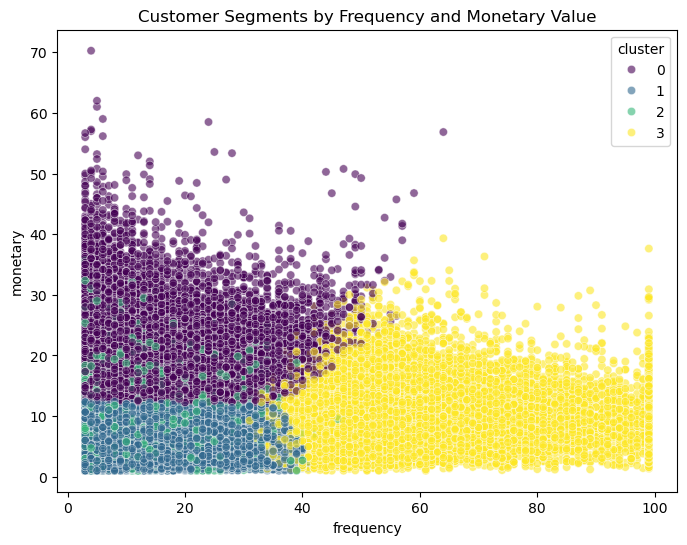

In [17]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=customer_rfm, x="frequency", y="monetary", hue="cluster", palette="viridis", alpha=0.6)
plt.title("Customer Segments by Frequency and Monetary Value")
plt.show()

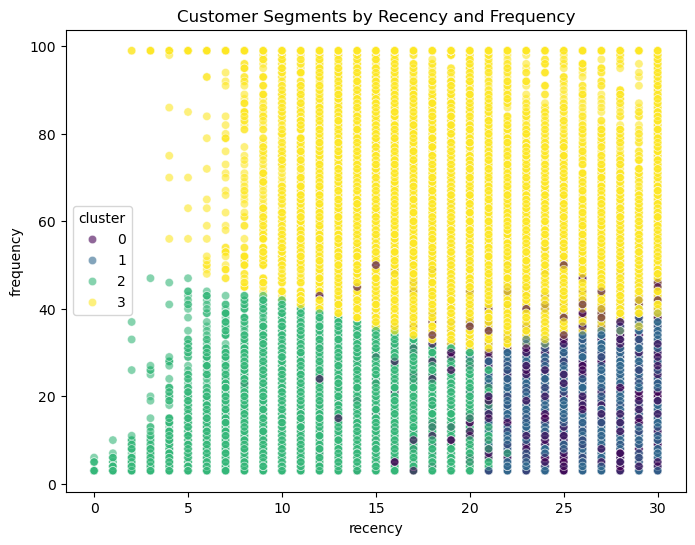

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=customer_rfm, x="recency", y="frequency", hue="cluster", palette="viridis", alpha=0.6)
plt.title("Customer Segments by Recency and Frequency")
plt.show()

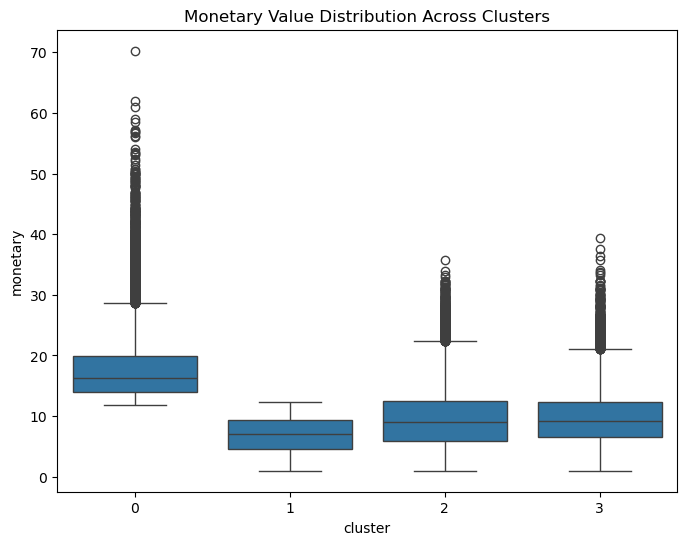

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(data=customer_rfm, x="cluster", y="monetary")
plt.title("Monetary Value Distribution Across Clusters")
plt.show()

In [20]:
# PRODUCT-LEVEL FEATURES

# Total number of times each product was ordered
product_orders = order_data.groupby("product_id")["order_id"].count().reset_index()
product_orders.columns = ["product_id", "total_orders"]

# Reorder ratio per product
reorder_ratio = order_data.groupby("product_id")["reordered"].mean().reset_index()
reorder_ratio.columns = ["product_id", "reorder_ratio"]

# Merge both
product_features = product_orders.merge(reorder_ratio, on="product_id")

# Add product name, aisle, department
product_features = product_features.merge(products_full[["product_id", "product_name", "aisle", "department"]], 
                                          on="product_id", 
                                          how="left")

product_features.head()

,product_id,total_orders,reorder_ratio,product_name,aisle,department
0,1,1852,0.613391,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,90,0.133333,All-Seasons Salt,spices seasonings,pantry
2,3,277,0.732852,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,329,0.446809,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,15,0.600000,Green Chile Anytime Sauce,marinades meat preparation,pantry


In [21]:
# POPULARITY LABEL (High = 1, Low = 0)

threshold = product_features["total_orders"].quantile(0.75)

product_features["popular"] = (product_features["total_orders"] >= threshold).astype(int)

product_features["popular"].value_counts()

popular
0    37253
1    12424
Name: count, dtype: int64

In [22]:
# Encode categorical features
le_aisle = LabelEncoder()
le_dept = LabelEncoder()

product_features["aisle_encoded"] = le_aisle.fit_transform(product_features["aisle"])
product_features["dept_encoded"] = le_dept.fit_transform(product_features["department"])

In [23]:
# Features (X) and Target (y)
X = product_features[["reorder_ratio", "aisle_encoded", "dept_encoded"]]
y = product_features["popular"]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
# LOGISTIC REGRESSION
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_prob_lr)

lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc

(0.7546296296296297,
 0.5215004574565416,
 0.22937625754527163,
 0.3186137506987144,
 np.float64(0.7717897237133714))

In [25]:
# DECISION TREE CLASSIFIER
dt = DecisionTreeClassifier(max_depth=10, random_state=42)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_prob_dt)

dt_accuracy, dt_precision, dt_recall, dt_f1, dt_auc

(0.7863325281803543,
 0.591321897073663,
 0.4716297786720322,
 0.5247369599283636,
 np.float64(0.8240532714472313))

In [26]:
# RANDOM FOREST CLASSIFIER
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)

rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc

(0.7894524959742351,
 0.6074357572443958,
 0.4470824949698189,
 0.5150672229949004,
 np.float64(0.8391203751835938))

In [27]:
model_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "Accuracy": [lr_accuracy, dt_accuracy, rf_accuracy],
    "Precision": [lr_precision, dt_precision, rf_precision],
    "Recall": [lr_recall, dt_recall, rf_recall],
    "F1 Score": [lr_f1, dt_f1, rf_f1],
    "ROC-AUC": [lr_auc, dt_auc, rf_auc]
})

model_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.754630,0.521500,0.229376,0.318614,0.771790
1,Decision Tree,0.786333,0.591322,0.471630,0.524737,0.824053
2,Random Forest,0.789452,0.607436,0.447082,0.515067,0.839120


In [28]:
import numpy as np

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
0,reorder_ratio,0.727388
2,dept_encoded,0.146130
1,aisle_encoded,0.126481


C:\Users\madhu\AppData\Local\Temp\ipykernel_30040\2587106275.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_departments.values, y=top_departments.index, palette='viridis')


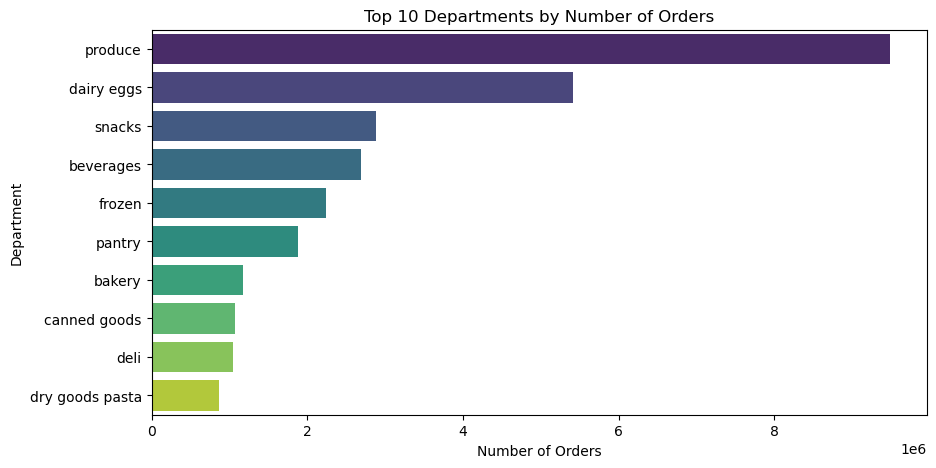

In [29]:
plt.figure(figsize=(10,5))
top_departments = order_data['department'].value_counts().head(10)

sns.barplot(x=top_departments.values, y=top_departments.index, palette='viridis')
plt.title("Top 10 Departments by Number of Orders")
plt.xlabel("Number of Orders")
plt.ylabel("Department")
plt.show()

C:\Users\madhu\AppData\Local\Temp\ipykernel_30040\2261391163.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_aisles.values, y=top_aisles.index, palette='magma')


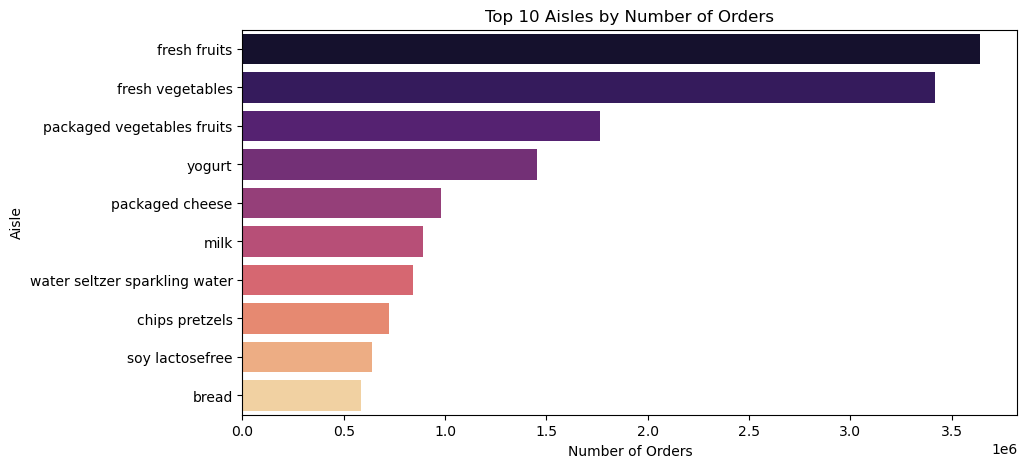

In [30]:
plt.figure(figsize=(10,5))
top_aisles = order_data['aisle'].value_counts().head(10)

sns.barplot(x=top_aisles.values, y=top_aisles.index, palette='magma')
plt.title("Top 10 Aisles by Number of Orders")
plt.xlabel("Number of Orders")
plt.ylabel("Aisle")
plt.show()

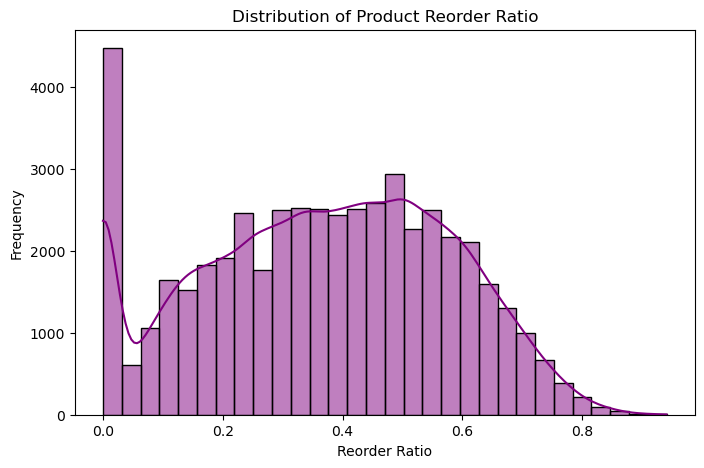

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(product_features['reorder_ratio'], bins=30, kde=True, color='purple')
plt.title("Distribution of Product Reorder Ratio")
plt.xlabel("Reorder Ratio")
plt.ylabel("Frequency")
plt.show()

C:\Users\madhu\AppData\Local\Temp\ipykernel_30040\1077194728.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=order_data['order_dow'], palette='coolwarm')


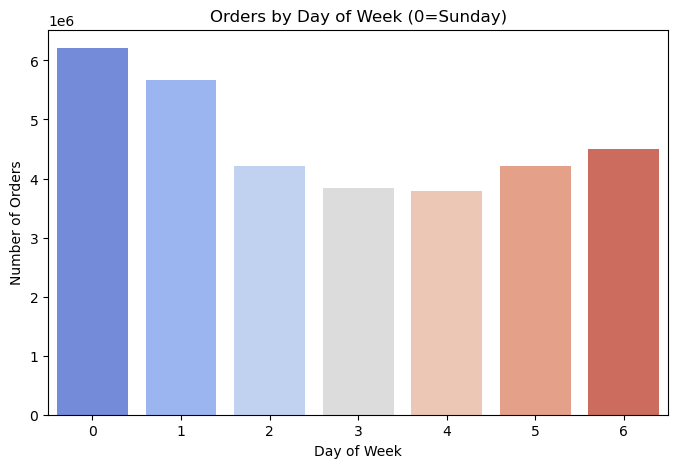

In [32]:
plt.figure(figsize=(8,5))
sns.countplot(x=order_data['order_dow'], palette='coolwarm')
plt.title("Orders by Day of Week (0=Sunday)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.show()

C:\Users\madhu\AppData\Local\Temp\ipykernel_30040\3724312248.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=order_data['order_hour_of_day'], palette='plasma')


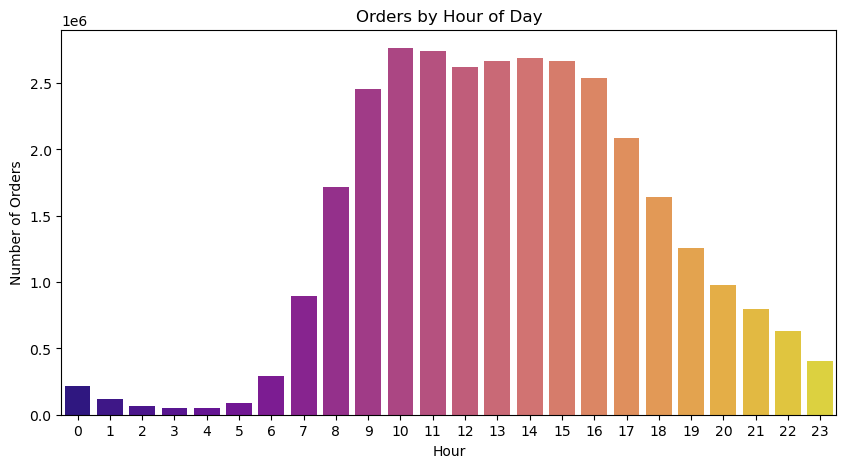

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(x=order_data['order_hour_of_day'], palette='plasma')
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Orders")
plt.show()

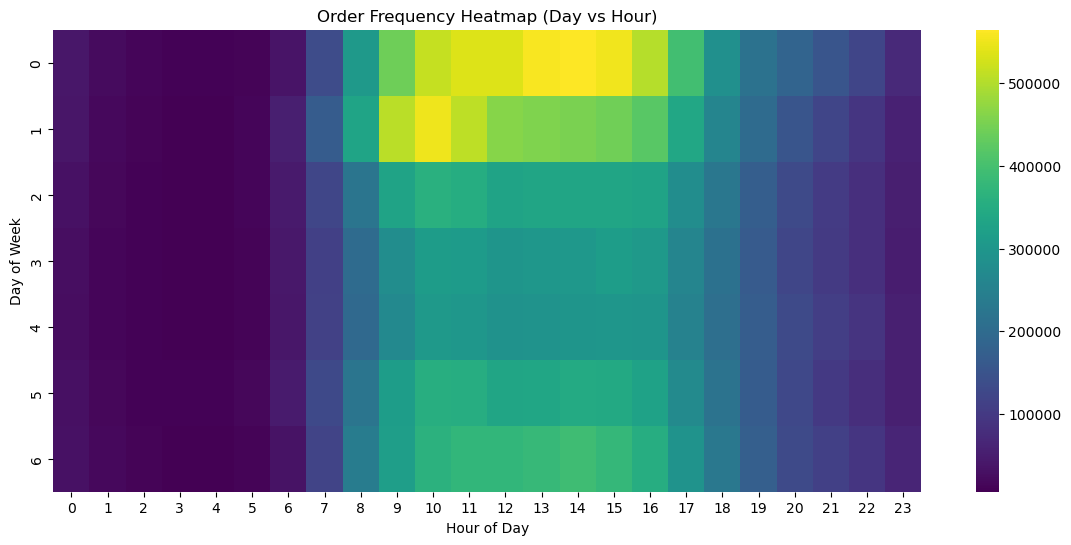

In [34]:
heat_data = order_data.pivot_table(
    index="order_dow", 
    columns="order_hour_of_day", 
    values="order_id", 
    aggfunc="count"
)

plt.figure(figsize=(14,6))
sns.heatmap(heat_data, cmap="viridis")
plt.title("Order Frequency Heatmap (Day vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()